# Running first Tests with Parcels

## Setup

In [15]:
import xarray as xr
import cmocean as cmo

from datetime import datetime, timedelta

import numpy as np

import parcels

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt

In [16]:
# Load ETOPO1
ds_bath = xr.open_dataset("/albedo/work/user/quraus001/bath/ETOPO_2022_v1_60s_N90W180_bed.nc")

# Crop to Fram Strait region
ds_fram_bath = ds_bath.sel(
    lon=slice(-35, 35),    
    lat=slice(70, 85)      
)

## Quick look at the model data

In [3]:
# Gridded example file from Claudia at 100m depth
#file = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/Arc22.gridded_100m_oce_2006_2009_new.nc"
file = "/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_withdepth.nc"
ds = xr.open_dataset(file)

In [4]:
ds

<xarray.Dataset> Size: 8GB
Dimensions:  (depth: 1, time: 365, lat: 825, lon: 800)
Coordinates:
  * time     (time) object 3kB 2002-01-01 23:57:30 ... 2002-12-31 23:57:30
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
  * depth    (depth) float64 8B 0.0
Data variables:
    temp     (depth, time, lat, lon) float64 2GB ...
    salt     (depth, time, lat, lon) float64 2GB ...
    u        (depth, time, lat, lon) float64 2GB ...
    v        (depth, time, lat, lon) float64 2GB ...

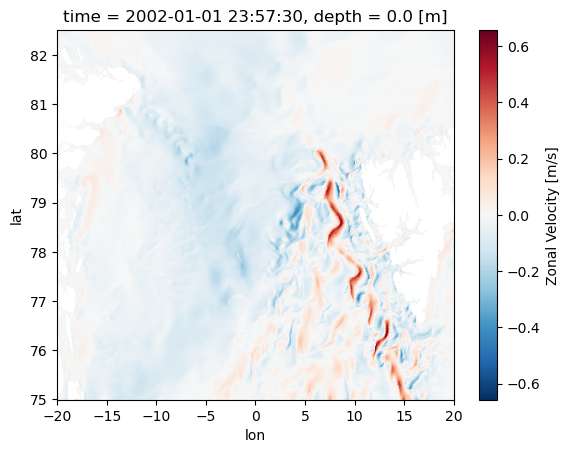

In [6]:
ds.u.isel(time=0).plot()

In [6]:
U = ds['uo']
V = ds['vo']

# Compute derivatives directly; xarray handles broadcasting if coords are properly defined
dVdx = V.differentiate('longitude')
dUdy = U.differentiate('latitude')

# Relative vorticity: dV/dx - dU/dy
vorticity = dVdx - dUdy
vorticity.name = "vorticity"

# Save to NetCDF
#vorticity.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc")

In [9]:
vorticity.to_netcdf("/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc")

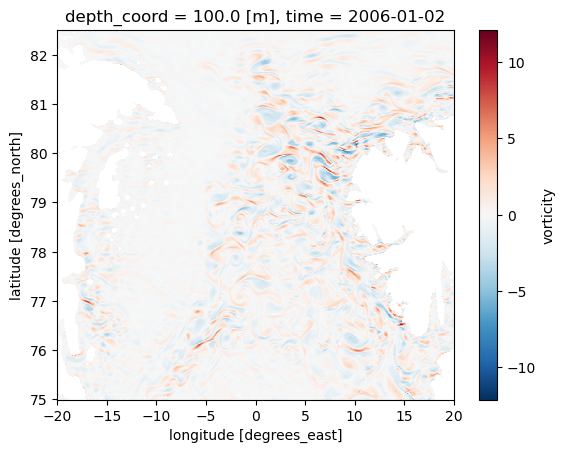

In [8]:
vorticity.isel(time=0).plot()

In [4]:
ds_vort = xr.open_dataset("/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc")
ds_vort

<xarray.Dataset> Size: 8GB
Dimensions:      (latitude: 825, longitude: 800, depth_coord: 1, time: 1460)
Coordinates:
  * latitude     (latitude) float64 7kB 75.0 75.01 75.02 ... 82.48 82.49 82.5
  * longitude    (longitude) float64 6kB -20.0 -19.95 -19.9 ... 19.9 19.95 20.0
  * depth_coord  (depth_coord) float64 8B 100.0
  * time         (time) datetime64[ns] 12kB 2006-01-02 2006-01-03 ... 2010-01-01
Data variables:
    vorticity    (time, depth_coord, latitude, longitude) float64 8GB ...

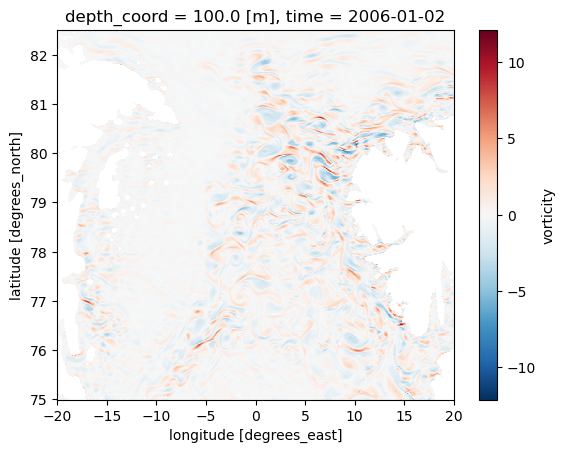

In [5]:
ds_vort.vorticity.isel(time=0).plot()

## Parcels Setup

In [3]:
#inpath = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/"
inpath = "/albedo/work/user/quraus001/processed_data/gridded/"
file   = "Arc40.2002.oce.mean.sub_gridded.nc"#"Arc22.gridded_100m_oce_2006_2009_new.nc"
fname  = f"{inpath}/Arc40.2002.oce.mean.sub_gridde*.nc"
#filenames = {"U": fname, "V": fname, }

outpath  = "/albedo/home/quraus001/FESOM-FS-subduction/outdata/"
outfname = "surface-test"
outfile  = f"{outpath}{outfname}.zarr"

In [4]:
filenames = {
    'U': inpath +file,
    'V': inpath +file,
    "T": inpath +file,
    "S": inpath +file,
    #"vorticity": "/albedo/work/user/quraus001/processed_data/gridded/vorticity-test_Arc22.gridded_100m_oce_2006_2009_new.nc",
}

variables = {
    'U': 'u',
    'V': 'v',
    "T": 'temp',
    "S": 'salt',
    #"vorticity": 'vorticity',
}

dimensions = {
    'lon': 'lon',
    'lat': 'lat',
    'time': 'time',
    #'depth': 'depth',
}

fieldset = parcels.FieldSet.from_netcdf(
    filenames,
    variables,
    dimensions,
    #indices={'depth': [0]},  # fixed 0m layer
    allow_time_extrapolation=True
)

## Particle Setup

In [ ]:
from parcels import AdvectionRK4 
from parcels import JITParticle, Variable

# STEP 1: Set up your particle release locations
n = 20                               # number of particles 
lons = np.linspace(5,10,n)#np.full(n, 3)                 
lats = np.full(n, 78.5)#np.linspace(78, 80, n)
depths = np.full(n, 0.0)           # all at 100m depth (fixed layer)

from datetime import timedelta

start_datetime = fieldset.time_origin.time_origin + timedelta(days=90)
start_time = (start_datetime - fieldset.time_origin.fulltime).total_seconds()
# STEP 2: Create the ParticleSet

class SampleParticle(JITParticle):
    #vorticity = Variable('vorticity', dtype=np.float32)
    temperature = Variable('temperature', dtype=np.float32, initial=np.nan)
    salinity    = Variable('salinity', dtype=np.float32, initial=np.nan)

pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=SampleParticle,#parcels.JITParticle,
    lon=lons,
    lat=lats,
    depth=depths,
    time = start_time
    #allow_time_extrapolation=True
)

TypeError: unsupported operand type(s) for +: 'int' and 'cftime._cftime.DatetimeNoLeap'

### Write Kernels

In [13]:
def SampleTS(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]
    #particle.vorticity = fieldset.vorticity[time, particle.depth, particle.lat, particle.lon]

## Compute trajectories

In [14]:
pset.execute(
    [AdvectionRK4, SampleTS],
    runtime=timedelta(days=50),             
    dt=timedelta(minutes=30),              
    output_file=pset.ParticleFile(name=outfname, outputdt=timedelta(hours=12)) #hours=12
)

INFO: Output files are stored in surface-test.zarr.
100%|██████████| 4320000.0/4320000.0 [00:12<00:00, 357609.75it/s]


## Look at data

In [8]:
ds = xr.open_zarr(outfname + ".zarr", consolidated=True)
ds

<xarray.Dataset> Size: 57kB
Dimensions:      (trajectory: 20, obs: 100)
Coordinates:
  * obs          (obs) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * trajectory   (trajectory) int64 160B 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
Data variables:
    lat          (trajectory, obs) float32 8kB dask.array<chunksize=(20, 1), meta=np.ndarray>
    lon          (trajectory, obs) float32 8kB dask.array<chunksize=(20, 1), meta=np.ndarray>
    salinity     (trajectory, obs) float32 8kB dask.array<chunksize=(20, 1), meta=np.ndarray>
    temperature  (trajectory, obs) float32 8kB dask.array<chunksize=(20, 1), meta=np.ndarray>
    time         (trajectory, obs) object 16kB dask.array<chunksize=(20, 1), meta=np.ndarray>
    z            (trajectory, obs) float32 8kB dask.array<chunksize=(20, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4SampleTS
    parcels_mesh:           spherical
    parcels_version:        3.1.2

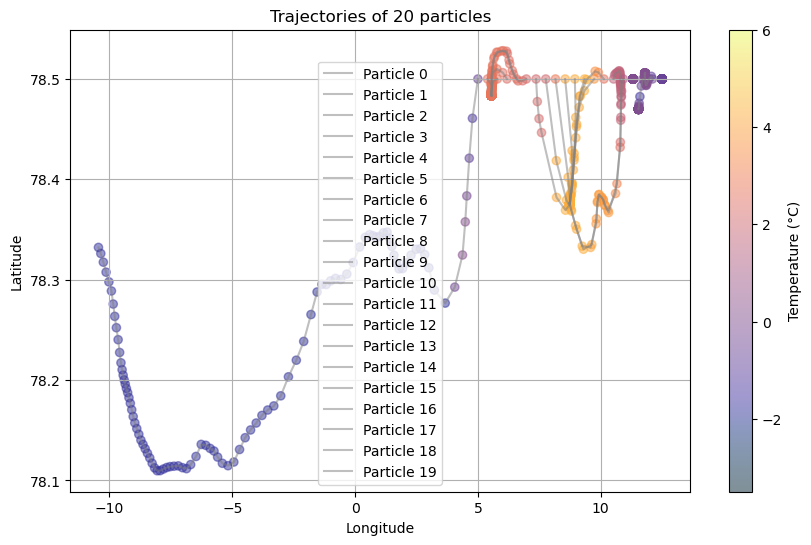

In [9]:
#ds = xr.open_zarr(outfile)

plt.figure(figsize=(10,6))
for pid in ds.trajectory:
    plt.plot(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), label=f"Particle {pid.values}", color="grey", alpha=0.5)
    plt.scatter(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), c=ds.temperature.sel(trajectory=pid), cmap=cmo.cm.thermal, alpha=0.5, vmin=-3.5, vmax=6) # 0,5
plt.colorbar(label="Temperature (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Trajectories of 20 particles")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def get_colormap_colors(colormap='plasma', num_colors=20):
    # Create a linear space of values from 0 to 1
    values = np.linspace(0, 1, num_colors)
    
    # Get the colormap from matplotlib or try from cmocean
    try:
        cmap = plt.get_cmap(colormap)
    except ValueError:
        # If the colormap is not found, use cmocean
        cmap = getattr(cmo.cm, colormap)

    
    # Get the colors corresponding to the values
    colors = [cmap(val) for val in values]
    
    return colors

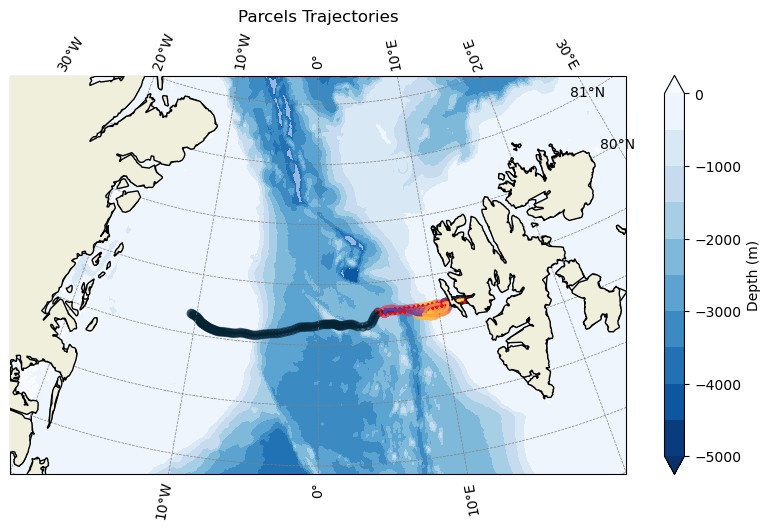

In [11]:
colors = get_colormap_colors(colormap='thermal', num_colors=20)

fig = plt.figure(figsize=(8, 6))
proj = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)

# Set extent for Fram Strait (in degrees; note lat/lon in PlateCarree for setting extent)
ax.set_extent([-20, 20, 75, 82], crs=ccrs.PlateCarree())

# Plot the bathymetry
bathy_data = ds_fram_bath['z']
lon = ds_fram_bath['lon']
lat = ds_fram_bath['lat']

# Contourf or pcolormesh for bathymetry
cs = ax.contourf(
    lon, lat, bathy_data,
    levels=np.arange(-5000, 500, 500),
    cmap="Blues_r",
    extend='both',
    transform=ccrs.PlateCarree()
)

plt.colorbar(cs, ax=ax, orientation='vertical', label='Depth (m)', shrink=0.7)

# Add map features
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Plot each particle's trajectory
for pid, color in zip(ds.trajectory, colors):
    ax.plot(
        ds.lon.sel(trajectory=pid),
        ds.lat.sel(trajectory=pid),
        transform=ccrs.PlateCarree(),
        label=f"Particle {pid.values}",
        linewidth=2,
        color=color,
    )
    ax.scatter(ds.lon.sel(trajectory=pid), ds.lat.sel(trajectory=pid), c=ds.temperature.sel(trajectory=pid), cmap=cmo.cm.thermal, alpha=0.5, vmin=0, vmax=5, transform=ccrs.PlateCarree())


# Optional: mark starting locations
ax.scatter(
    ds.lon.isel(obs=0),
    ds.lat.isel(obs=0),
    color='red',
    s=20,
    transform=ccrs.PlateCarree(),
    label="Start",
    marker="x"
)

plt.title("Parcels Trajectories")
#plt.legend()
plt.tight_layout()
plt.show()